# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
conda update python

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append("..")

In [4]:
from util import show, plot_images, plot_tensors

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from skimage import data, img_as_float, img_as_ubyte

from skimage.color import gray2rgb



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Initial shape: (90, 90, 5, 3)


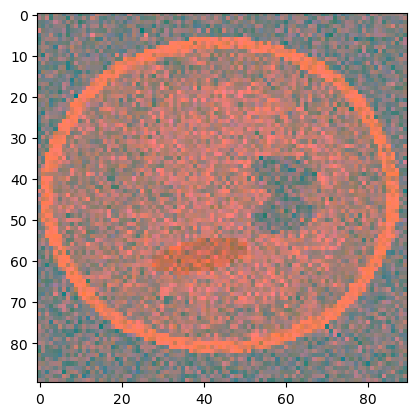

In [5]:

mat = scipy.io.loadmat('/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR1.mat')
noisy_image = mat['data_gaussian']

# Check the initial shape of the image
print("Initial shape:", noisy_image.shape)

# Select a slice of the reshaped image (for example, the first channel)
slice_to_visualize = noisy_image[:, :, 0]

# Display the selected slice
plt.imshow(slice_to_visualize, cmap='gray')  # Assuming grayscale image, change cmap if RGB
plt.show()

(90, 90, 15)


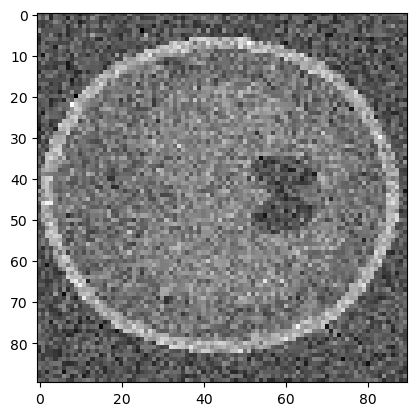

In [22]:
import numpy as np


# Reshape the data to combine the last two dimensions (assuming this is your intent)
reshaped_image = noisy_image.reshape(90, 90, -1) # Now it's (90, 90, 15)
print(reshaped_image.shape)


# Select a slice of the reshaped image (for example, the first channel)
slice_to_visualize = reshaped_image[:, :, 0]

# Display the selected slice
plt.imshow(slice_to_visualize, cmap='gray')  # Assuming grayscale image, change cmap if RGB
plt.show()


In [9]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

# Model

For our model, we use a deep convolutional network.

In [46]:
import sys
sys.path.append('../../')

from models.dncnn import DnCNN
model = DnCNN(channels=15, num_of_layers=17)

TypeError: __init__() got an unexpected keyword argument 'num_of_layers'

In [11]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

572160

In [12]:
reshaped_image.ravel().shape

(121500,)

# Training

In [13]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

(90, 90, 15)


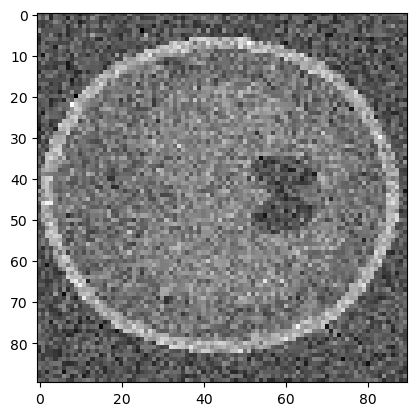

In [17]:
import torch
import numpy as np

# Assuming you have a model object and a device object
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assuming reshaped_image is your NumPy array
reshaped_image_np = np.array(reshaped_image)  # Convert NumPy array to PyTorch tensor
print(reshaped_image_np.shape)
image_tensor = torch.from_numpy(reshaped_image_np).to(device)  # Convert to tensor and move to device


import matplotlib.pyplot as plt

# Select a slice of the reshaped image (for example, the first channel)
slice_to_visualize = image_tensor[:, :, 0]

# Display the selected slice
plt.imshow(slice_to_visualize, cmap='gray')  # Assuming grayscale image, change cmap if RGB
plt.show()


Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
( 0 ) Loss: 	 0.00178 	Val Loss: 	 0.00088
(90, 90)
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
( 10 ) Loss: 	 0.00096 	Val Loss: 	 0.00094
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape of X[0, 0]: torch.Size([90, 90])
Shape o

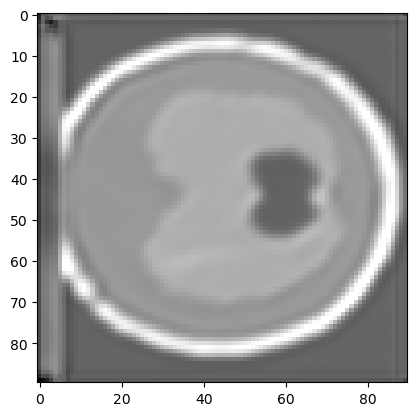

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming you have loaded your image into 'image_tensor'

losses = []
val_losses = []
best_val_loss = 1
model = model.double()  # Convert model parameters to Double type, only once

for i in range(500):
    model.train()
    

    # Permute dimensions to rearrange them in the required order
    input_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.permute(0, 3, 1, 2)

    input_tensor = input_tensor.double()  # Convert input tensor to Double type

    # Now, you can pass the reshaped input tensor to your model
    net_output = model(input_tensor)
  
    model.train()
    
    # Assuming 'masker' is defined and initialized properly
    net_input, mask = masker.mask(input_tensor, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output * mask, input_tensor * mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(input_tensor, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output * mask, input_tensor * mask)
        val_losses.append(val_loss.item())
        
        print("(", i, ") Loss: \t", round(loss.item(), 5), "\tVal Loss: \t", round(val_loss.item(), 5))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Assuming denoised is the denoised image array
            denoised = np.clip(model(input_tensor).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
            print(denoised.shape)  # This should print (height, width)


plt.imshow(denoised, cmap='gray')
plt.show()

In [31]:
denoised = best_images[-1]

In [ ]:
compare_psnr(denoised, image)

30.292080062230315

In [ ]:
inset_x_min = 100
inset_x_max = 160
inset_y_min = 230
inset_y_max = 290

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

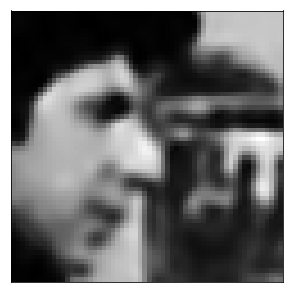

In [ ]:
show(get_inset(denoised))